In [128]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [129]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196'

TARGETNAME = 'placement'

In [130]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_matches.pickle'))

In [131]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Guardian,Set7_Guild,...,TFT7_Aatrox_item2,TFT7_AurelionSol,TFT7_AurelionSol_item0,TFT7_AurelionSol_item1,TFT7_AurelionSol_item2,TFT7_Skarner_item2,TFT7_Sejuani_item1,TFT7_Sejuani_item2,TFT7_Senna_item1,TFT7_Senna_item2
0,NA1_4354923614,2,TFT7_Augment_AssassinEmblem,TFT7_Augment_BandOfThieves1,TFT6_Augment_CelestialBlessing1,2.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NA1_4354923614,1,TFT6_Augment_TomeOfTraits1,TFT7_Augment_BandOfThieves1,TFT7_Augment_RevelTrait,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4354923614,5,TFT6_Augment_TrueTwos,TFT6_Augment_Featherweights1,TFT6_Augment_PandorasItems,1.0,1.0,0.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4354923614,6,TFT6_Augment_RichGetRicher,TFT7_Augment_WarriorTrait,TFT6_Augment_ItemGrabBag1,2.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4354923614,3,TFT7_Augment_MageConference,TFT7_Augment_AxiomArc1,TFT6_Augment_ItemGrabBag1,NaN,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,NA1_4356203136,8,TFT7_Augment_AFK,TFT6_Augment_SecondWind1,TFT6_Augment_ThrillOfTheHunt2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8244,NA1_4356203136,7,TFT6_Augment_TinyTitans,TFT6_Augment_CelestialBlessing1,TFT6_Augment_Ascension,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8245,NA1_4356203136,4,TFT6_Augment_Electrocharge1,TFT6_Augment_SecondWind1,TFT7_Augment_RagewingScorch,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8246,NA1_4356203136,1,TFT6_Augment_Weakspot,TFT6_Augment_Diversify1,TFT6_Augment_Diversify2,1.0,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [133]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 14.01 Mb (16.6% reduction)


In [134]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Guardian,Set7_Guild,...,TFT7_Aatrox_item2,TFT7_AurelionSol,TFT7_AurelionSol_item0,TFT7_AurelionSol_item1,TFT7_AurelionSol_item2,TFT7_Skarner_item2,TFT7_Sejuani_item1,TFT7_Sejuani_item2,TFT7_Senna_item1,TFT7_Senna_item2
1,NA1_4354923614,1,TFT6_Augment_TomeOfTraits1,TFT7_Augment_BandOfThieves1,TFT7_Augment_RevelTrait,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4354923614,5,TFT6_Augment_TrueTwos,TFT6_Augment_Featherweights1,TFT6_Augment_PandorasItems,1.0,1.0,0.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4354923614,6,TFT6_Augment_RichGetRicher,TFT7_Augment_WarriorTrait,TFT6_Augment_ItemGrabBag1,2.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4354923614,3,TFT7_Augment_MageConference,TFT7_Augment_AxiomArc1,TFT6_Augment_ItemGrabBag1,NaN,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NA1_4354923614,4,TFT6_Augment_SalvageBin,TFT6_Augment_ItemGrabBag1,TFT6_Augment_PandorasItems,NaN,0.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,NA1_4356203136,8,TFT7_Augment_AFK,TFT6_Augment_SecondWind1,TFT6_Augment_ThrillOfTheHunt2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8244,NA1_4356203136,7,TFT6_Augment_TinyTitans,TFT6_Augment_CelestialBlessing1,TFT6_Augment_Ascension,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8245,NA1_4356203136,4,TFT6_Augment_Electrocharge1,TFT6_Augment_SecondWind1,TFT7_Augment_RagewingScorch,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8246,NA1_4356203136,1,TFT6_Augment_Weakspot,TFT6_Augment_Diversify1,TFT6_Augment_Diversify2,1.0,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [136]:
# Check NA
check_NA(raw_df)

augment1                 3
augment2                30
Set7_Assassin         5333
Set7_Bruiser          3391
Set7_Cavalier         5400
                      ... 
TFT7_Skarner_item2    8241
TFT7_Sejuani_item1    8143
TFT7_Sejuani_item2    8201
TFT7_Senna_item1      8227
TFT7_Senna_item2      8238
Length: 264, dtype: int64


In [137]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [138]:
raw_df = impute(raw_df)

In [139]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [140]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [141]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
NA1_4354923614    8
NA1_4357018695    8
NA1_4356326337    8
NA1_4356286405    8
NA1_4357111004    8
                 ..
NA1_4353915037    8
NA1_4354198267    8
NA1_4354950522    8
NA1_4354907610    8
NA1_4356203136    8
Name: match_id, Length: 1031, dtype: int64 

augment0
TFT6_Augment_PortableForge        391
TFT6_Augment_SecondWind2          259
TFT7_Augment_UrfsGrabBag1         259
TFT6_Augment_SecondWind1          209
TFT6_Augment_Weakspot             202
                                 ... 
TFT7_Augment_MysticTrait2           2
TFT7_Augment_AssassinCutthroat      2
TFT7_Augment_WarriorEmblem          2
TFT6_Augment_Diversify2             1
TFT7_Augment_AstralTrait2           1
Name: augment0, Length: 185, dtype: int64 

augment1
TFT6_Augment_SecondWind1                  378
TFT6_Augment_Weakspot                     327
TFT6_Augment_TinyTitans                   301
TFT6_Augment_PortableForge                241
TFT6_Augm

In [142]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [143]:
raw_df.describe()

,placement,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Guardian,Set7_Guild,Set7_Legend,Set7_Mage,Set7_Ragewing,Set7_Scalescorn,...,TFT7_Ezreal,TFT7_Sejuani,TFT7_Yone,TFT7_Nunu,TFT7_Gnar,TFT7_DragonGreen,TFT7_Skarner,TFT7_Nidalee,TFT7_Elise,TFT7_AurelionSol
count,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,...,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000
mean,4.500000,0.361057,0.494544,0.286736,0.214961,1.044617,0.020126,0.111785,0.445926,0.106450,...,0.075048,0.302498,0.073109,0.132274,0.196169,0.222963,0.027158,0.061712,0.068986,0.004728
std,2.291427,0.708415,0.673401,0.669166,0.435465,1.227271,0.140440,0.456011,0.638284,0.388156,...,0.407661,0.694892,0.384764,0.513748,0.574993,0.614581,0.249631,0.418672,0.374355,0.081527
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,3.000000,4.000000,4.000000,3.000000,6.000000,1.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000


In [144]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8248 entries, 0 to 8247
Columns: 267 entries, match_id to TFT7_Senna_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 14.0+ MB


2022-06-29 09:21:17,855 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


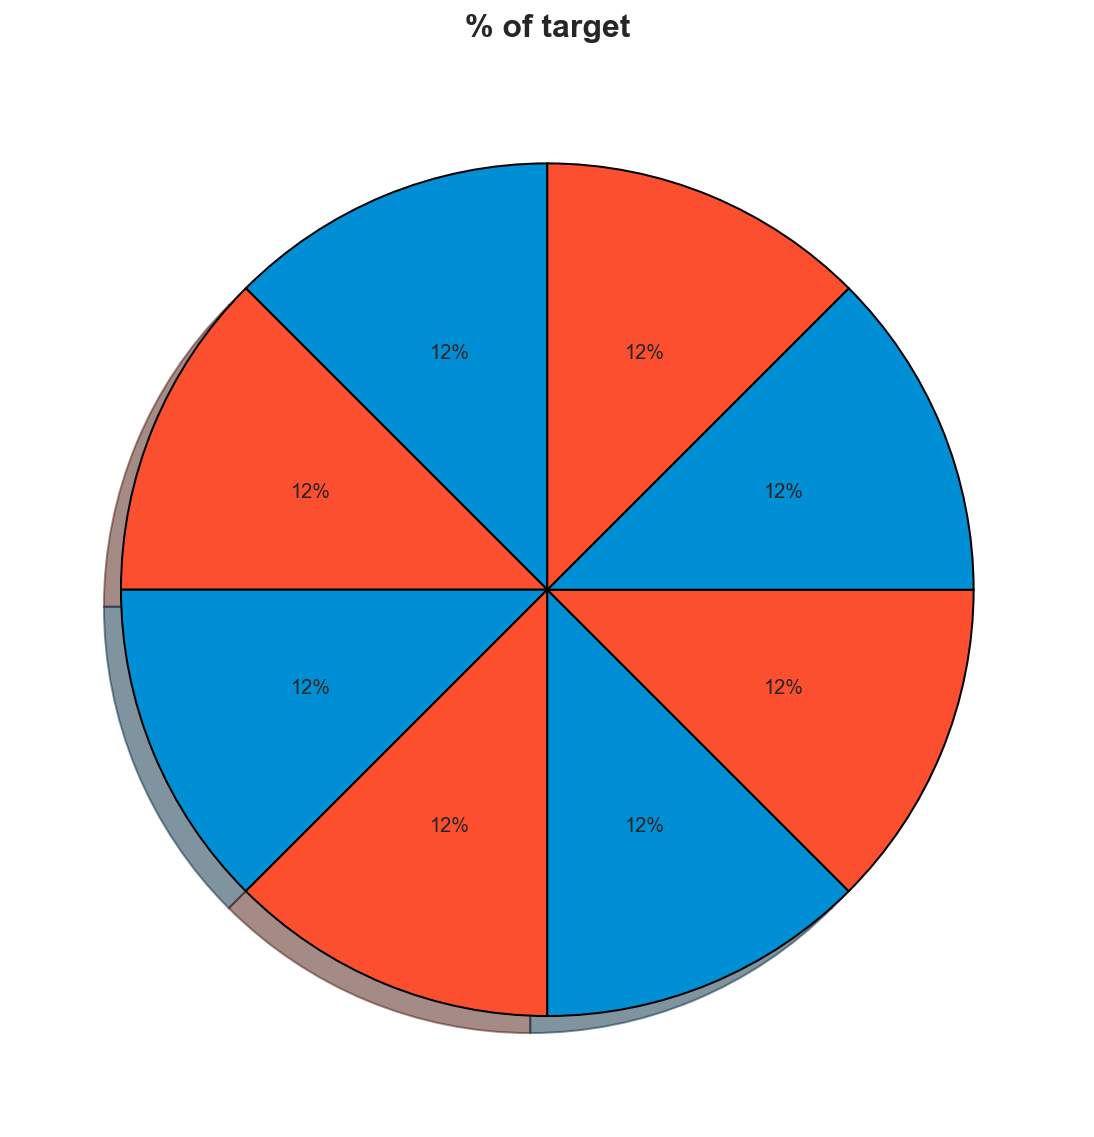

In [145]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [146]:
X = raw_df.drop(['match_id'], axis=1)


In [147]:
y = X.pop(TARGETNAME)

In [148]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [149]:
X.fillna('', inplace=True)

In [150]:
y

0       2
1       1
2       5
3       6
4       3
       ..
8243    8
8244    7
8245    4
8246    1
8247    5
Name: placement, Length: 8248, dtype: int8

In [151]:
X.dtypes

augment0               object
augment1               object
augment2               object
Set7_Assassin         float32
Set7_Bruiser          float32
                       ...   
TFT7_Skarner_item2     object
TFT7_Sejuani_item1     object
TFT7_Sejuani_item2     object
TFT7_Senna_item1       object
TFT7_Senna_item2       object
Length: 265, dtype: object

In [152]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [153]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [154]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8248 entries, 0 to 8247
Columns: 265 entries, augment0 to TFT7_Senna_item2
dtypes: int64(87), object(178)
memory usage: 16.7+ MB


In [156]:
X

,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Guardian,Set7_Guild,Set7_Legend,Set7_Mage,...,TFT7_Aatrox_item2,TFT7_AurelionSol,TFT7_AurelionSol_item0,TFT7_AurelionSol_item1,TFT7_AurelionSol_item2,TFT7_Skarner_item2,TFT7_Sejuani_item1,TFT7_Sejuani_item2,TFT7_Senna_item1,TFT7_Senna_item2
0,TFT7_Augment_AssassinEmblem,TFT7_Augment_BandOfThieves1,TFT6_Augment_CelestialBlessing1,2,1,0,0,1,0,0,...,,0,,,,,,,,
1,TFT6_Augment_TomeOfTraits1,TFT7_Augment_BandOfThieves1,TFT7_Augment_RevelTrait,0,2,0,0,0,0,0,...,,0,,,,,,,,
2,TFT6_Augment_TrueTwos,TFT6_Augment_Featherweights1,TFT6_Augment_PandorasItems,1,1,0,0,3,0,0,...,,0,,,,,,,,
3,TFT6_Augment_RichGetRicher,TFT7_Augment_WarriorTrait,TFT6_Augment_ItemGrabBag1,2,1,0,0,1,0,0,...,,0,,,,,,,,
4,TFT7_Augment_MageConference,TFT7_Augment_AxiomArc1,TFT6_Augment_ItemGrabBag1,0,0,0,0,1,0,3,...,,0,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,TFT7_Augment_AFK,TFT6_Augment_SecondWind1,TFT6_Augment_ThrillOfTheHunt2,1,1,1,0,3,0,0,...,,0,,,,,,,,
8244,TFT6_Augment_TinyTitans,TFT6_Augment_CelestialBlessing1,TFT6_Augment_Ascension,0,0,0,0,0,0,0,...,,0,,,,,,,,
8245,TFT6_Augment_Electrocharge1,TFT6_Augment_SecondWind1,TFT7_Augment_RagewingScorch,0,0,0,0,0,0,0,...,,0,,,,,,,,
8246,TFT6_Augment_Weakspot,TFT6_Augment_Diversify1,TFT6_Augment_Diversify2,1,0,0,1,2,0,0,...,,0,,,,,,,,


In [157]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [171]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', tree_method='hist',
                    n_estimators=250, enable_categorical=True) #, use_label_encoder=False hist

In [186]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [187]:
# augment_oe.fit(X[categorical_cols[:3]])

In [188]:
# item_oe.fit(X[categorical_cols[3:]])

In [189]:
# categorical_cols[3:]

In [190]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", augment_oe, categorical_cols[:3]),
            ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
    ),
    xgb,
)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)
y_pred = logistic_regression_pipeline.predict(X_test)

In [192]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [193]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [194]:
len(y_test)

1238

In [195]:
y_pred.shape

(1238,)

In [196]:
def plot_oof(y_true, y_predict):
    # Plot y_true vs. y_pred
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_predict, s=3, color='r', alpha=0.5)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

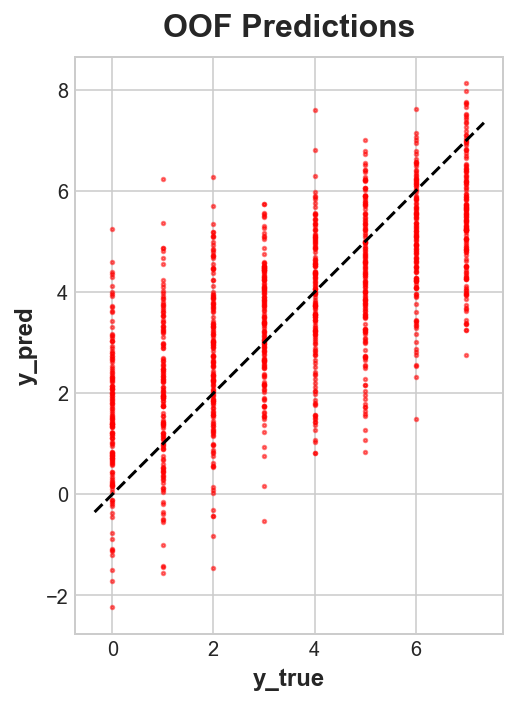

In [197]:
plot_oof(y_test, y_pred)

In [198]:
min(y_pred)

-2.2361252

In [199]:
# Get feature importances
xgb.feature_importances_

array([5.5259350e-04, 1.0329460e-03, 1.1503542e-03, 1.7807061e-03,
       1.1871498e-03, 1.0998087e-03, 2.1283068e-03, 2.1943303e-03,
       1.2660712e-03, 1.2206959e-03, 1.0517060e-03, 1.0329433e-03,
       2.2563802e-03, 3.4030976e-03, 1.3791589e-03, 1.5064734e-03,
       2.2635988e-03, 1.0141602e-03, 6.3344499e-04, 2.0784740e-03,
       1.5007860e-03, 1.8272928e-03, 1.7810753e-03, 1.0749145e-03,
       1.0848872e-03, 1.6290355e-03, 1.8981576e-03, 1.2357351e-03,
       1.9869483e-03, 2.0412533e-03, 2.9962661e-03, 2.2951737e-03,
       1.5018199e-03, 1.4876368e-03, 3.1819430e-03, 1.8463847e-03,
       1.6272221e-03, 1.0266150e-03, 8.6841459e-04, 2.2131191e-03,
       2.7291905e-04, 5.7751639e-04, 7.4216537e-04, 1.3331827e-03,
       1.2681793e-03, 5.7235296e-04, 1.3345254e-03, 8.5752871e-04,
       1.5705840e-03, 9.1144932e-04, 2.3320781e-03, 2.0907081e-03,
       1.5882860e-03, 1.5798745e-03, 3.4520177e-03, 1.9303670e-03,
       1.4836403e-03, 2.3377063e-03, 9.7550533e-04, 1.3953431e

In [200]:
mean_absolute_error(y_test, y_pred)

1.2993112117554602

In [201]:
mean_squared_error(y_test, y_pred)

2.6159364708570676

In [202]:
importances = xgb.feature_importances_

In [203]:
len(importances)

265